In [1]:
import random
import pandas as pd
import numpy as np
import math
import os
import sys

In [2]:
## Importing custom functions from different folder:

# Get the current directory
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
folder = 'Implementation'
data_folder = os.path.join(parent_dir, folder)

# Construct the full file path
file_ = 'utils_data'
full_path = os.path.join(data_folder, file_)
print(full_path)
print(data_folder)
sys.path.append(data_folder)  

# Load the functions from .py file  
try:
    #from utils_data import load_data, data_clustering, plot_data, cleaning_data, linear_transf
    #from utils_data import experimental_velocity, plot_velocity, saving_processed_data
    from utils_data import load_processed_data
    from utils_model import numericalSimulation, ComputeFunctional, ComputeVel
    from utils_model import generate_trajectory, plot_simulation, generate_trajectory_vel
except ModuleNotFoundError as e:
    print("ModuleNotFoundError:", e)

/Users/flaviaferrusmarimon/UB/MAM/TFM/Codes1/MotorControlPrediction/Implementation/utils_data
/Users/flaviaferrusmarimon/UB/MAM/TFM/Codes1/MotorControlPrediction/Implementation


# Loading processed data: 

In [3]:
# Loading the processed data: 
print('Loading processed data...')
n_clusters = 4
dfx = [[] for _ in range(n_clusters)]
dfy = [[] for _ in range(n_clusters)]
for cluster in range(n_clusters): 
    dfx[cluster] = load_processed_data(folder_path='processed_data', file_name='cluster{}_dfx.csv'.format(cluster))
    dfy[cluster] = load_processed_data(folder_path='processed_data', file_name='cluster{}_dfy.csv'.format(cluster))
results = load_processed_data(folder_path='processed_data', file_name='results.csv') 

Loading processed data...


In [4]:
results

,cluster,rectx,recty,idxrule,mean_T,max_vel
0,0,[ 9.5 10.75 11.5 12.75],[6.6 7.6 3.1 4.1],"[1814, 1404, 1654, 1791, 1291, 1672, 1632, 171...",1.319448,0.005534
1,1,[-12. -13.25 -10. -11.25],[-3.25 -4.25 -6.75 -7.75],"[1698, 1554, 1868, 1708, 1313, 1274, 1455, 141...",1.295982,0.005831
2,2,[11.5 12.75 9.5 10.75],[ 1.75 0.75 -1.75 -2.75],"[1487, 1293, 1305, 1366, 1198, 1132, 1353, 128...",1.251862,0.004535
3,3,[ -9.5 -10.75 -11.5 -12.75],[ 3. 4. -0.5 0.5],"[2042, 1197, 1369, 1063, 1131, 1495, 1305, 112...",1.304000,0.004591


# Parameter fitting: 

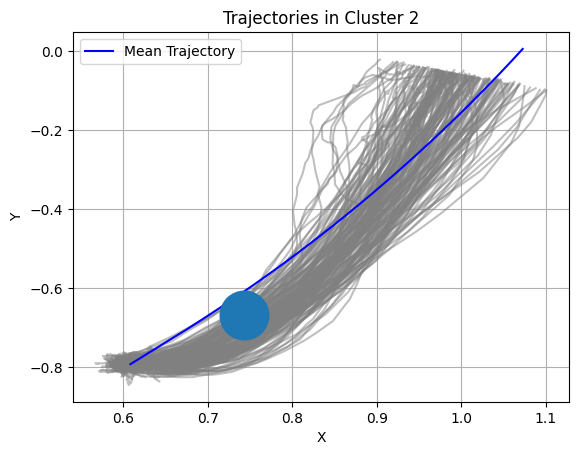

In [5]:
cluster = 0
x, y = generate_trajectory(plotting = False)
plot_simulation(x, y, dfx[cluster], dfy[cluster])

## Optimizing the velocity (from utils):

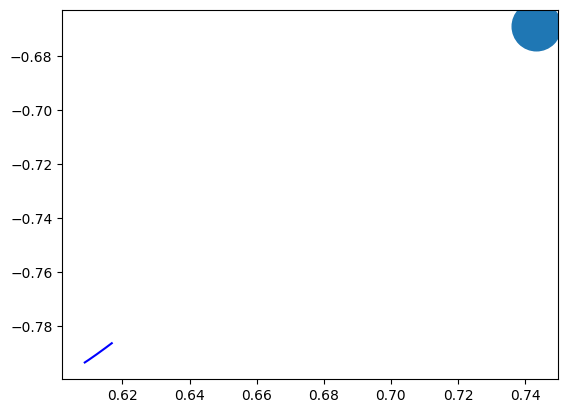

In [22]:
x_, y_ = generate_trajectory_vel_(plotting = True, 
                                 T = results[results['cluster'] == cluster].mean_T.values[0],
                                 vel = results[results['cluster'] == cluster].max_vel.values[0])

## Optimizing velocity (from hard code: )

In [ ]:
T = results[results['cluster'] == cluster].mean_T.values[0]
vel = results[results['cluster'] == cluster].max_vel.values[0]
random.seed(10)
def ComputeVel(parameters):
    gamma, epsilon, alpha = parameters
    parameters2 = ( 3.7, -0.15679707,  0.97252444,  0.54660283, -6.75775885, -0.06253371)
    x, y, v, w, ux, uy, T2= numericalSimulation(x_0 = (0,0,0,0),  p_T = 1.0, 
                        sigma = 0, gamma = gamma, epsilon = epsilon, alpha = alpha,
                        u_0 = parameters2[:2], l_0 = parameters2[2:], 
                        i_max = 1000, dt = timestep,
                        Autoregr = False, 
                        Arc = True, angle=math.pi*7/24, angle0=0, p=(.2,0), r=.1)
    
    vel_max = np.max(np.sqrt(np.square(v) + np.square(w)))
    
    return (T2 - T)**2 + (vel_max - vel)**2
res3=scipy.optimize.minimize(ComputeVel, (.5, .5, .5), args=(), method=None)
res3.x, ComputeVel(res3.x), (T,vel)

# FUNCTIONS

In [20]:
import matplotlib.pyplot as plt
import scipy

def plot_trajectory(x, y, showing = True, via = True, plot_title = 'Mean Trajectory'): 
    plt.plot(x,y,color='blue', label=plot_title, alpha = 1)
    if via:
        angle=math.pi*7/24
        T_1=.2
        plt.plot(np.cos(angle*(T_1-1)),np.sin(angle*(T_1-1)),marker='o',markersize=35)
    if showing: 
        plt.show()

def generate_trajectory_vel_(params=(0.5, 0.5, 0.5), 
                             parameters=(3.7, -0.15679707, 0.97252444, 0.54660283, -6.75775885, -0.06253371), 
                             sigma=0, timestep=1/500, plotting=True, T=1.3, vel=0.1):
    '''
    Function that computes and plots the trajectory for the initial given parameters 
    (sigma, gamma, epsilon and alpha) found by optimizing the velocity in 
    terms of the parameters. 
    ''' 
    # Define a partial function to pass additional arguments to ComputeVel
    partial_compute_vel = lambda params: ComputeVel(params, vel=vel, T=T, sigma=sigma)
    
    # Use scipy.optimize.minimize with the partial function
    new_params = scipy.optimize.minimize(partial_compute_vel, params, args=(), method=None)
    gamma, epsilon, alpha = new_params.x
    
    # Call numericalSimulation with the optimized parameters
    x, y, v, w, ux, uy, T= numericalSimulation(x_0 = (0,0,0,0),  p_T = 1.0, 
                        sigma = sigma, gamma = gamma, epsilon = epsilon, alpha = alpha,
                        u_0 = parameters[:2], l_0 = parameters[2:], 
                        i_max = 1000, dt = timestep,
                        Autoregr = True, 
                        Arc = True, angle=math.pi*7/24, angle0=0, p=(.2,0), r=.1
                        )
    # Plot trajectory if required
    if plotting: 
        plot_trajectory(x, y, showing=True)
    
    return x, y


## Numerical simulation

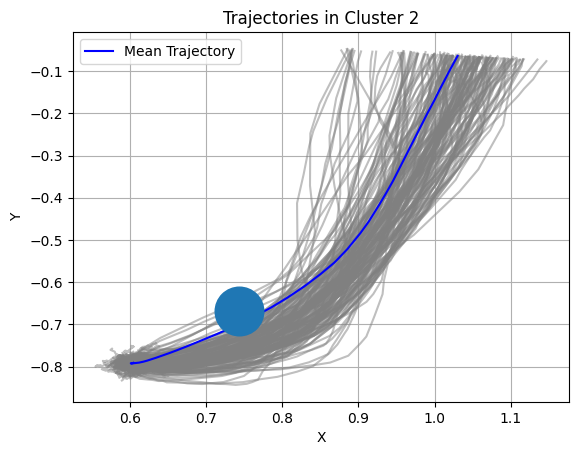

In [32]:
plot_simulation(rotated_dfx[cluster].mean(axis = 0), rotated_dfy[cluster].mean(axis = 0), rotated_dfx[cluster], rotated_dfy[cluster])